In [2]:
# Install the necessary dependencies
!pip install selenium
!apt update
!apt install chromium-chromedriver


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 40.8 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,425 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,276 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/u

In [15]:
# Import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import re
import networkx as nx
from selenium import webdriver
from selenium.webdriver.common.by import By
from wordcloud import STOPWORDS
from wordcloud import WordCloud

In [16]:
# Configure Chromedriver options
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Configure variables
_driver = webdriver.Chrome(options=options)
_url = "https://testdevjobs.com/location/remote-united-kingdom"

In [17]:
# Modified from @ https://colab.research.google.com/drive/14kXYQCSGVye4bBKKExtuHOeq32bc4xbW?usp=sharing#scrollTo=dRAMB1_yt1jJ

def getJobListings(driver: str, url: str):
  driver.get(url)
  job_listings = _driver.find_elements(By.XPATH, "//*[@class='job-deatils']")
  return job_listings

def fetchJobDetailsAndAddToList(driver: str, selector: str, empty_list):
  job_detail = driver.find_element(By.XPATH, selector).text
  empty_list.append(job_detail)

def traverseJobs(driver: str, url: str):
  job_listings = getJobListings(driver, url)
  job_count = 0
  job_title = []

  job_location = []
  job_skills = []
  job_id = []

  for job in job_listings:
    fetchJobDetailsAndAddToList(driver, "//*[@class='ml-5 jobtitle is-size-5 has-text-weight-semibold']", job_title)
    fetchJobDetailsAndAddToList(driver, "//*[@class='tags ml-5 mr-1 mb-0']", job_location)
    fetchJobDetailsAndAddToList(driver, "//*[@class='tags ml-5 mr-1']", job_skills)
    job_count =+ 1
    job_id.append(job_count)

  jobs_panda_frame = pd.DataFrame(list(zip(job_id, job_title, job_location, job_skills)), columns = ['ID', 'Title', 'Location', 'Skills'])
  return jobs_panda_frame.to_csv('jobs.csv')

traverseJobs(_driver, _url)

In [18]:
# Prepare data for Voyant processing

jobs_data = pd.read_csv("/content/jobs.csv")
skills_data = jobs_data["Skills"]
skills_data.head()

# Save into a new CSV file
skills_data.to_csv("skills.csv")

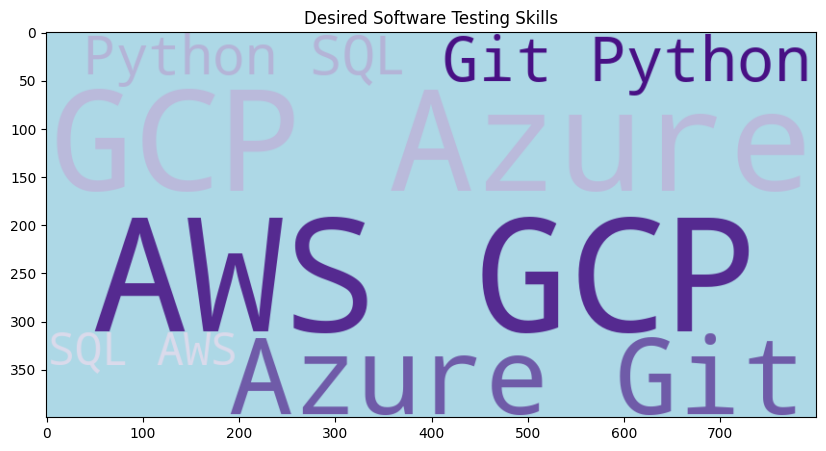

In [19]:
# Create a word cloud
text = " ".join(skills for skills in jobs_data.Skills.astype(str))
stopwords = set(STOPWORDS)
wordcloud = WordCloud().generate(text)

# Customise the word cloud
wordcloud = WordCloud(width=800, height=400, stopwords = stopwords, background_color='lightblue', max_words=100, colormap='Purples_r').generate(text) # https://www.geeksforgeeks.org/python/generating-word-cloud-python
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.title("Desired Software Testing Skills")
plt.show()

In [21]:
# Prepare data for Palladio processing before working with OpenRefine.

# Remove repetitions
jobs_data.drop_duplicates(inplace = True)
jobs_data.head()
jobs_data.to_csv("updated_jobs.csv")

location_data = jobs_data["Location"]
location_data.to_csv("locations.csv")
location_data.head()

,Location
0,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
1,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
2,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
3,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
4,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time


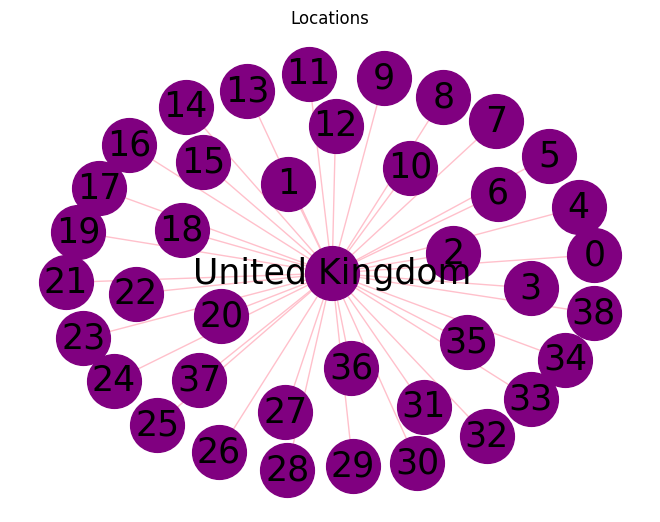

In [64]:
# Load CSV exported from OpenRefine
locations_csv = pd.read_csv("/content/locations_for_palladio.csv")
locations_csv.head()

# Create a network graph @ https://medium.com/@harshkjoya/connecting-the-dots-creating-network-graphs-from-pandas-dataframes-with-networkx-9c4fb60089cf
G = nx.Graph()
G.add_nodes_from(locations_csv['Column'])
G.add_nodes_from(locations_csv['Location'])
edges = [(row['Column'], row['Location']) for index, row in locations_csv.iterrows()]
G.add_edges_from(edges)

# Draw the graph
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='purple', font_size=25, font_color='black', edge_color="pink")
plt.title("Locations")
plt.show()